In [1]:
from config.configuration import RunDetails

# runDetail = RunDetails('config.yml', 'Compare-Sksmta-eval')
runDetail = RunDetails('config.yml', 'ASVspoof-2019_2025-03-24-1_large-batch')

notebookName = 'audio-deepfake-detection-testing'

In [2]:
configFilename = runDetail.configFilename
runJobId = runDetail.jobId

In [3]:
import joblib
import numpy as np
from sklearn.metrics import confusion_matrix

import config.configuration as configuration
from preprocessors.mel_spectrogram import MelSpectrogramPreprocessor
from notebook_utils import notebookToPython
from postprocessors.confusion_matrix_plot import ConfusionMatrixPlot
from postprocessors.roc_curve_plot import RocCurvePlot
from processors.basic_model_evaluation_processor import BasicModelEvaluationProcessor
from processors.model_evaluation_result import ModelEvaluationResult
from readers.label_reader import readLabelsWithJob

In [4]:
config = configuration.ConfigLoader(configFilename)

notebookToPython(notebookName)
job = config.getJobConfig(runJobId)

import json
prettyJson = json.dumps(job.__dict__, indent=4)
print(f"job: {prettyJson}")

if (job.newModelGenerated):
    raise ValueError("This notebook is meant for testing. Select a job with a value for 'persisted-model' set.")

Write python file
Using configured model name: results/2025-03-24T22-21-36.689419/01_ASVspoof-2019_training_2025-03-25T07-47-11.409349_random_000186.libjob
Assigned model name: results/2025-03-24T22-21-36.689419/01_ASVspoof-2019_training_2025-03-25T07-47-11.409349_random_000186.libjob
job: {
    "jobId": "ASVspoof-2019_2025-03-24-1_large-batch",
    "inputFileBatchSize": 4000,
    "outputFolder": "output",
    "dataPathRootRaw": "$HOMEDRIVE$HOMEPATH/workspace/Deepfake/data/ASVspoof-2019",
    "dataPathRoot": "C:/Users/tubas/workspace/Deepfake/data/ASVspoof-2019",
    "dataPathSuffix": "LA/ASVspoof2019_LA_eval/flac",
    "dataExtension": ".flac",
    "trainingSplitRandomState": 3,
    "labelFilename": "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt",
    "executeToCategoricalForLabels": true,
    "classes": [
        "spoof",
        "bonafide"
    ],
    "numClasses": 2,
    "sampleRate": 16000,
    "duration": 5,
    "numMels": 128,
    "maxTimeSteps": 109,
    "kerne

In [5]:
generator = MelSpectrogramPreprocessor()
model = joblib.load(job.persistedModel)
evaluationProc = BasicModelEvaluationProcessor(job, model)

MelSpectrogramPreprocessor


In [6]:
fullDataPath = job.fullJoinFilePath(job.dataPathRoot, job.dataPathSuffix)
y_test = readLabelsWithJob(job)

Loading C:/Users/tubas/workspace/Deepfake/data/ASVspoof-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt...


In [7]:
from preprocessors.abstract_preprocessor import AbstractPreprocessor
from preprocessors.preprocessor_factory import PreprocessorFactory


preproc_factory = PreprocessorFactory()
preprocessor: AbstractPreprocessor = preproc_factory.newPreprocessor(job.preprocessor)

MelSpectrogramPreprocessor


In [8]:
X_test, y_test, true_labels = preprocessor.extract_features_jobSource(job, job.dataPathSuffix)

Loading C:/Users/tubas/workspace/Deepfake/data/ASVspoof-2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt...
fullDataPath: C:/Users/tubas/workspace/Deepfake/data/ASVspoof-2019/LA/ASVspoof2019_LA_eval/flac
Loading audio files: 3561
Loading audio files: 7122
Loading audio files: 10683
Loading audio files: 14244
Loading audio files: 17805
Loading audio files: 21366
Loading audio files: 24927
Loading audio files: 28488
Loading audio files: 32049
Loading audio files: 35610
Loading audio files: 39171
Loading audio files: 42732
Loading audio files: 46293
Loading audio files: 49854
Loading audio files: 53415
Loading audio files: 56976
Loading audio files: 60537
Loading audio files: 64098
Loading audio files: 67659
Loading audio files: 71220
Number of audio files loaded: 71237


In [9]:
results: ModelEvaluationResult = evaluationProc.process(X_test, y_test, true_labels)

2227/2227 ━━━━━━━━━━━━━━━━━━━━ 60s 27ms/step
  Batches: 1 - Files: 71237 - Score: 0.9175428499234948 - Elements: 71237


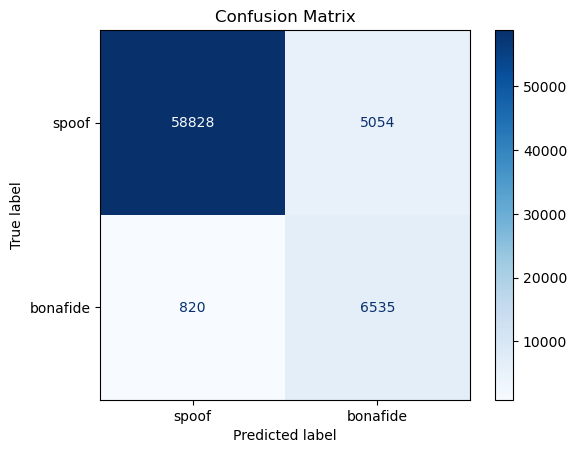

In [10]:
cm_plot = ConfusionMatrixPlot()
cm_plot.plotFromResults(results, job)

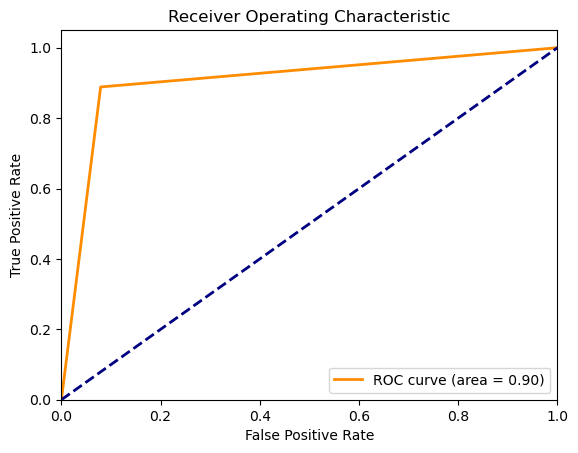

In [11]:
roc_plot = RocCurvePlot()
roc_plot.plotFromResults(results)

In [12]:
print("\n")
report = evaluationProc.reportSnapshot()
evaluationProc.writeReportToFile(job.persistedModelResults, report)

print(report)



---- Testing (start) ----
start time: 2025-04-08T03:29:44.696240+00:00
end time: 2025-04-08T03:30:50.921721+00:00
elapsed: 0:01:06.225481

model file: results/2025-03-24T22-21-36.689419/01_ASVspoof-2019_training_2025-03-25T07-47-11.409349_random_000186.libjob
batch count: 1
file count: 71237
accuracy_score: 0.9175428499234948

job: {
    "jobId": "ASVspoof-2019_2025-03-24-1_large-batch",
    "inputFileBatchSize": 4000,
    "outputFolder": "output",
    "dataPathRootRaw": "$HOMEDRIVE$HOMEPATH/workspace/Deepfake/data/ASVspoof-2019",
    "dataPathRoot": "C:/Users/tubas/workspace/Deepfake/data/ASVspoof-2019",
    "dataPathSuffix": "LA/ASVspoof2019_LA_eval/flac",
    "dataExtension": ".flac",
    "trainingSplitRandomState": 3,
    "labelFilename": "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt",
    "executeToCategoricalForLabels": true,
    "classes": [
        "spoof",
        "bonafide"
    ],
    "numClasses": 2,
    "sampleRate": 16000,
    "duration": 5,
    "numMe